In [1]:
# Import statements
 
import os
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.data import random_split
from torcheval.metrics.functional import binary_f1_score
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import monai
import h5py
import torch
import numpy as np
import random
import warnings
import torchmetrics
import piq
from loss_functions import *


os.environ["CUDA_VISIBLE_DEVICES"]="2"


2024-07-31 10:12:23.491204: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 10:12:26.818699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# User-defined parameters

train_batch_size = 224 # Batch size used for train and val, bigger since we are training on patches
test_batch_size = 64 # Batch size used for test, may need to be smaller since we are testing on full images
num_epochs = 150 # TUNE, want it to be big enough that model converges 
eval_freq = 1 # How often to evaluate model on val set, set to 1 to evaluate every epoch or ~5 if validation is taking too long
learning_rate = 0.001
loss_name = "edge_loss"
net_name = "unet_stride_1"
save_path = 'experiment_models' # Parent logging directory
run_name = f'{net_name}_loss_{loss_name}_lr_{learning_rate}' # Unique identifier for this experiment

data_file_name = 'data_file_name.h5' # (Relative) file path to read data from

In [3]:
# Automatically defined parameters

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running model on device: {device}')


# Set up save paths

os.makedirs(save_path, exist_ok=True)
full_save_path = os.path.join(save_path, run_name)
txt_log_path = os.path.join(full_save_path, 'training_log.txt')
model_save_path = os.path.join(full_save_path, 'models')
figure_save_path = os.path.join(full_save_path, 'figures')

if os.path.exists(full_save_path):
    warnings.warn(f'Save path {full_save_path} already exists')
os.makedirs(full_save_path, exist_ok=True)
os.makedirs(model_save_path, exist_ok=True)
os.makedirs(figure_save_path, exist_ok=True)


Running model on device: cuda


In [4]:
# Define dataloader

class h5DenoisingDataset(torch.utils.data.Dataset):
    """
    Torch dataset class for reading in clean/noisy data from h5 files. 

    @args:
        h5_filepath (str): path to the h5 file containing the data
        split (str, {'train','val','test'}): indicates which data split this is
        patch_size (int): size of the patches to extract from the images, used only for training and validation
    @rets:
        clean_image (torch.tensor): clean image to use as ground truth, torch tensor of shape (C, H, W)
        noisy_image (torch.tensor): noisy image to use as input, torch tensor of shape (C, H, W)
        noise_sigma (float): noise level of the noisy image
        sample_id (str): ID identifying this sample

    """
    def __init__(self, h5_filepath, split, patch_size=64):

        # Save variables
        self.h5_filepath = h5_filepath
        self.split = split
        self.patch_size = patch_size

        # Get all keys from h5 file
        with h5py.File(h5_filepath, 'r') as f:
            self.keys = list(f.keys())
            
        # Split the keys into train, val, and test by case number
        all_cases = list(set([int(key.split('_')[1]) for key in self.keys]))
        random.seed(42)
        random.shuffle(all_cases)
        n = len(all_cases)
        if split == 'train': self.cases = all_cases[:int(0.6*n)]
        elif split == 'val': self.cases = all_cases[int(0.6*n):int(0.8*n)]
        elif split == 'test': self.cases = all_cases[int(0.8*n):]
        else: raise ValueError('Invalid split argument. Must be one of {train, val, test}')

        # Get all keys for this split
        self.keys = [key for key in self.keys if int(key.split('_')[1]) in self.cases]

        # Define transforms
        self.train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomCrop(self.patch_size), # Random crop train set to increase training data variance
        ])
        self.val_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.CenterCrop(self.patch_size), # Center crop val set to maintain consistent val set that runs quickly
        ])
        self.test_transform = transforms.Compose([
            transforms.ToTensor() # No crop on test set
        ])
        
    def __getitem__(self, index):

        # Load image at this index
        with h5py.File(self.h5_filepath, 'r') as h5file:
            clean_image = h5file[self.keys[index]]['clean'][()]
            noisy_image = h5file[self.keys[index]]['noisy'][()]
            noise_sigma = h5file[self.keys[index]]['noise_sigma'][()]

        # Transform input
        seed = np.random.randint(214)
        random.seed(seed)
        torch.manual_seed(seed)
        if self.split == 'train': clean_image = self.train_transform(clean_image)
        elif self.split == 'val': clean_image = self.val_transform(clean_image)
        else: clean_image = self.test_transform(clean_image)
        
        # Transform output
        random.seed(seed)
        torch.manual_seed(seed)
        if self.split == 'train': noisy_image = self.train_transform(noisy_image)
        elif self.split == 'val': noisy_image = self.val_transform(noisy_image)
        else: noisy_image = self.test_transform(noisy_image)

        return clean_image, noisy_image, noise_sigma, self.keys[index]

    def __len__(self):
        return len(self.keys)

In [5]:
# Define util functions

def print_and_save(print_str, file_path):
    """
    Prints string and saves string to file_path
    """
    print(print_str)
    with open(file_path, 'a') as f:
        f.write(print_str + '\n')

def compute_denoising_metrics(predicted, true):
    """
    Computes common denoising metrics
    Takes batches of tensors as input (B, C, H, W), returns average metrics as floats
    """
    ssim = torchmetrics.functional.image.structural_similarity_index_measure(predicted, true, data_range=220)
    psnr = torchmetrics.functional.image.peak_signal_noise_ratio(predicted, true, data_range=220) 
    mse = torchmetrics.functional.mean_squared_error(predicted, true)
    # TODO: add more denoising metrics here, particulalry those that capture high frequency information. Potential ref: https://lightning.ai/docs/torchmetrics/stable/image/
    return ssim.item(), psnr.item(), mse.item()

        

In [6]:
# Define datasets 

trainset = h5DenoisingDataset(h5_filepath=data_file_name, split='train')
valset = h5DenoisingDataset(h5_filepath=data_file_name, split='val')
testset = h5DenoisingDataset(h5_filepath=data_file_name, split='test')

print_and_save(f"Length of trainset: {len(trainset)}", txt_log_path)
print_and_save(f"Length of valset: {len(valset)}", txt_log_path)
print_and_save(f"Length of testset: {len(testset)}", txt_log_path)


# Define dataloaders

trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(valset, batch_size=train_batch_size, shuffle=False, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, num_workers=4)



Length of trainset: 9000
Length of valset: 3000
Length of testset: 3000



Split: Train 



Size of clean images: torch.Size([224, 1, 64, 64]), min of clean image: 0.003758140839636326, max of clean image: 41.57078170776367
Size of noisy images: torch.Size([224, 1, 64, 64]), min of noisy image: 0.035747330635786057, max of noisy image: 40.29505157470703
Noise sigma: 2.507228136062622


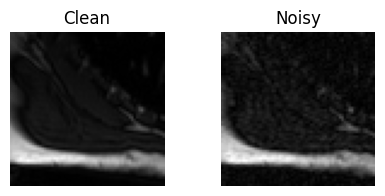

Size of clean images: torch.Size([224, 1, 64, 64]), min of clean image: 0.005517769604921341, max of clean image: 18.96061134338379
Size of noisy images: torch.Size([224, 1, 64, 64]), min of noisy image: 0.03347168117761612, max of noisy image: 19.91613006591797
Noise sigma: 4.577208042144775


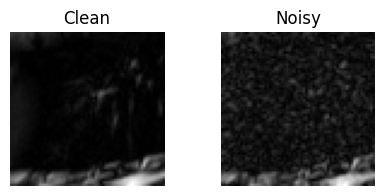


Split: Val 

Size of clean images: torch.Size([224, 1, 64, 64]), min of clean image: 0.01829051412642002, max of clean image: 5.664815902709961
Size of noisy images: torch.Size([224, 1, 64, 64]), min of noisy image: 0.055371467024087906, max of noisy image: 13.559003829956055
Noise sigma: 4.22586727142334


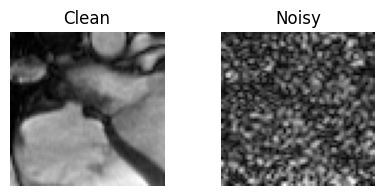

Size of clean images: torch.Size([224, 1, 64, 64]), min of clean image: 0.03314466401934624, max of clean image: 28.016647338867188
Size of noisy images: torch.Size([224, 1, 64, 64]), min of noisy image: 0.2519013583660126, max of noisy image: 32.476112365722656
Noise sigma: 2.7627272605895996


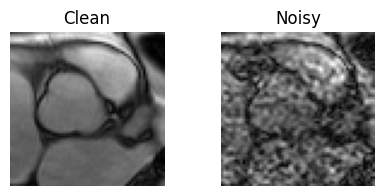


Split: Test 

Size of clean images: torch.Size([64, 1, 192, 256]), min of clean image: 0.002692905254662037, max of clean image: 96.94705200195312
Size of noisy images: torch.Size([64, 1, 192, 256]), min of noisy image: 0.02251277305185795, max of noisy image: 101.34236907958984
Noise sigma: 2.3655216693878174


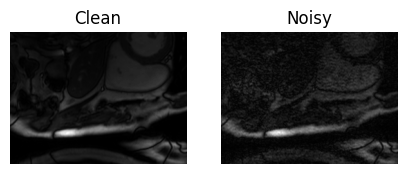

Size of clean images: torch.Size([64, 1, 192, 256]), min of clean image: 0.0004425784863997251, max of clean image: 72.92073059082031
Size of noisy images: torch.Size([64, 1, 192, 256]), min of noisy image: 0.0065290676429867744, max of noisy image: 73.68963623046875
Noise sigma: 4.85683012008667


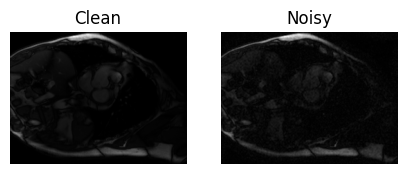

In [7]:
# Visualize a few samples from each split as a gut check

num_plots = 2
do_check = True

if do_check:
    for split, loader in [("Train",trainloader), ("Val",valloader), ("Test",testloader)]:

        # Get this split's data loader
        print('\nSplit:',split,'\n')
        dataiter = iter(loader)

        for plot_count in range(num_plots):

            # Sample from loader
            clean_image, noisy_image, noise_sigma, key = next(dataiter)
            
            # Print info about sample and plot it
            batch_ind = 0

            print(f'Size of clean images: {clean_image.shape}, min of clean image: {torch.min(clean_image[batch_ind])}, max of clean image: {torch.max(clean_image[batch_ind])}')
            print(f'Size of noisy images: {noisy_image.shape}, min of noisy image: {torch.min(noisy_image[batch_ind])}, max of noisy image: {torch.max(noisy_image[batch_ind])}')
            print(f'Noise sigma: {noise_sigma[batch_ind]}')
            
            fig, ax = plt.subplots(1,2,figsize=(5,2))
            ax[0].imshow(clean_image[batch_ind][0].numpy(),cmap='gray')
            ax[0].axis('off')
            ax[0].set_title('Clean')
            ax[1].imshow(noisy_image[batch_ind][0].numpy(),cmap='gray')
            ax[1].axis('off')
            ax[1].set_title('Noisy')
            plt.show()
            plt.close()
            

In [8]:
# Define model
# TODO: decide on architecture to run experiments with
#net = monai.networks.nets.HighResNet(spatial_dims=2, in_channels=1, out_channels=1)

channels = [32, 64, 128, 256, 512]  # Example channels configuration
strides = [1, 1, 1, 1]  # Example strides configuration (len(channels) - 1)
net = monai.networks.nets.UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=channels, strides=strides)
#net = monai.networks.nets.HighResNet(spatial_dims=2, in_channels=1, out_channels=1)

net.to(device)

# Define optimizer
# TODO: try out a few learning rates after finding a good architecture
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [9]:
# Define loss
# TODO: experiment and track performance with different loss functions
# TODO: keep code clean! Clean code -> clean experiments -> reproducible and confident results
#criterion = torch.nn.MSELoss()
#criterion = RiemannianLoss(gamma=0.75)
#criterion = torch.nn.L1Loss()
#criterion = torch.nn.HuberLoss(reduction='mean', delta=0.75)
criterion = EdgeLoss(sigma=0.7) #empirically set to 0.7 in the paper
#criterion = Charbonnier_Loss()
#criterion = FeaturePreservingLoss()
#criterion = GeneralizedLoss(alpha=1.25, c=2)
#criterion = DiceLoss()
#criterion = PSNR()

In [10]:
# Training loop

print_and_save("\nStarting training:", txt_log_path)

best_val_loss = np.inf

for epoch in range(num_epochs):

    running_loss = 0.0
    running_count = 0
    print_and_save('\nEpoch {}'.format(epoch), txt_log_path)

    # Put model in train mode
    net.train()
    
    for i, (clean_images, noisy_images, noise_sigmas, keys) in enumerate(tqdm(trainloader)):   

        # Put the tensors onto the device
        clean_images = clean_images.to(device)
        noisy_images = noisy_images.to(device)
        
        # Forward pass
        predicted_images = net(noisy_images)
        
        # Compute loss
        loss = criterion(predicted_images, clean_images)

        # Backward pass and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item()
        running_count += 1

    # Save train statistics 
    print_and_save('\tTrain loss: %.3f' %(running_loss / running_count), txt_log_path)

    # Validation loop
    if epoch % eval_freq == 0:

        # Put model in eval mode
        net.eval()
        with torch.no_grad():
            save_plot = True
            num_plots = 5
            running_loss = 0
            running_count = 0
            for i, (clean_images, noisy_images, noise_sigmas, keys) in enumerate(tqdm(valloader)):   

                # Send images to device and predict clean images
                clean_images = clean_images.to(device)
                noisy_images = noisy_images.to(device)
                predicted_images = net(noisy_images)

                # Save a num_plots number of plots if save_plot is True
                if save_plot and i<num_plots:
                    clean_image = clean_images[0][0].cpu().numpy()
                    noisy_image = noisy_images[0][0].cpu().numpy()
                    predited_image = predicted_images[0][0].detach().cpu().numpy()
                    key = keys[0]

                    # Set up figure save paths
                    full_figure_save_path = os.path.join(figure_save_path, 'val')
                    os.makedirs(full_figure_save_path, exist_ok=True)
                    full_figure_save_path = os.path.join(figure_save_path, 'val', key)
                    os.makedirs(full_figure_save_path, exist_ok=True)

                    # Plot and save
                    fig, ax = plt.subplots(1,3)
                    ax[0].imshow(noisy_image,cmap='gray')
                    ax[0].axis('off')
                    ax[0].set_title('Noisy')
                    ax[1].imshow(predited_image,cmap='gray')
                    ax[1].axis('off')
                    ax[1].set_title('Predict')
                    ax[2].imshow(clean_image,cmap='gray')
                    ax[2].axis('off')
                    ax[2].set_title('GT')
                    plt.savefig(os.path.join(full_figure_save_path, f'epoch_{epoch}.png'))
                    plt.close()

                # Track validation loss
                loss = criterion(predicted_images, clean_images)
                running_loss += loss.item()
                running_count += 1
      
                # Clean up memory
                del clean_images, noisy_images, noise_sigmas, keys, predicted_images
            
            print_and_save('\tValidation loss: %.3f' %(running_loss / running_count), txt_log_path)

            # Save model if this is the best model so far, according to the loss function
            if running_loss / running_count < best_val_loss:
                best_val_loss = running_loss / running_count
                torch.save(net.state_dict(), os.path.join(model_save_path, f'best_model.pth'))
                print_and_save(f'\tCheckpointing epoch {epoch} model at best_model.pth', txt_log_path)

# Save final model 
print_and_save(f'\nFinished training, saving final model at final_model.pth', txt_log_path)
torch.save(net.state_dict(), os.path.join(model_save_path, f'final_model.pth'))
        



Starting training:

Epoch 0


  0%|          | 0/41 [00:00<?, ?it/s]/home/lib16/mambaforge/envs/tutorials/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971873/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 41/41 [00:37<00:00,  1.11it/s]


	Train loss: 849.639


100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


	Validation loss: 644.681
	Checkpointing epoch 0 model at best_model.pth

Epoch 1


100%|██████████| 41/41 [00:31<00:00,  1.28it/s]


	Train loss: 758.660


100%|██████████| 14/14 [00:05<00:00,  2.34it/s]


	Validation loss: 545.292
	Checkpointing epoch 1 model at best_model.pth

Epoch 2


100%|██████████| 41/41 [00:31<00:00,  1.28it/s]


	Train loss: 689.556


100%|██████████| 14/14 [00:05<00:00,  2.37it/s]


	Validation loss: 497.860
	Checkpointing epoch 2 model at best_model.pth

Epoch 3


100%|██████████| 41/41 [00:32<00:00,  1.28it/s]


	Train loss: 644.202


100%|██████████| 14/14 [00:05<00:00,  2.39it/s]


	Validation loss: 549.344

Epoch 4


100%|██████████| 41/41 [00:32<00:00,  1.27it/s]


	Train loss: 614.901


100%|██████████| 14/14 [00:05<00:00,  2.50it/s]


	Validation loss: 496.852
	Checkpointing epoch 4 model at best_model.pth

Finished training, saving final model at final_model.pth


In [11]:
# Load chosen model
chosen_load_path = os.path.join(model_save_path, 'best_model.pth') # Can change this to load a different model
print_and_save(f'\nLoading model from {chosen_load_path} for final evaluations', txt_log_path)
net.load_state_dict(torch.load(chosen_load_path))


Loading model from testing_directory/unet_stride_1_loss_edge_loss_lr_0.001/models/best_model.pth for final evaluations


<All keys matched successfully>

In [12]:
# Run validation loop and save metrics for chosen model
 
print_and_save(f'\nRunning validation loop...', txt_log_path)
net.eval()
with torch.no_grad():
    all_ssim = []
    all_psnr = []
    all_mse = []
    for i, (clean_images, noisy_images, noise_sigmas, keys) in enumerate(tqdm(valloader)):   

        clean_images = clean_images.to(device)
        noisy_images = noisy_images.to(device)
        predicted_images = net(noisy_images)

        batch_ssim, batch_psnr, batch_mse = compute_denoising_metrics(predicted_images, clean_images)

        all_ssim += [batch_ssim]*clean_images.shape[0]
        all_psnr += [batch_psnr]*clean_images.shape[0]
        all_mse += [batch_mse]*clean_images.shape[0]
    
print_and_save(f'Validation SSIM: {np.mean(all_ssim)}', txt_log_path)
print_and_save(f'Validation PSNR: {np.mean(all_psnr)}', txt_log_path)
print_and_save(f'Validation MSE: {np.mean(all_mse)}', txt_log_path)


Running validation loop...


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]

Validation SSIM: 0.8474869511922201
Validation PSNR: 37.58519042460124
Validation MSE: 41.945967643737795


In [13]:
# Run test loop and save metrics for chosen model

print_and_save(f'\nRunning test loop...', txt_log_path)
net.eval()
with torch.no_grad():
    all_ssim = []
    all_psnr = []
    all_mse = []
    for i, (clean_images, noisy_images, noise_sigmas, keys) in enumerate(tqdm(testloader)):   

        clean_images = clean_images.to(device)
        noisy_images = noisy_images.to(device)
        predicted_images = net(noisy_images)

        batch_ssim, batch_psnr, batch_mse = compute_denoising_metrics(predicted_images, clean_images)

        all_ssim += [batch_ssim]*clean_images.shape[0]
        all_psnr += [batch_psnr]*clean_images.shape[0]
        all_mse += [batch_mse]*clean_images.shape[0]
    
print_and_save(f'Test SSIM: {np.mean(all_ssim)}', txt_log_path)
print_and_save(f'Test PSNR: {np.mean(all_psnr)}', txt_log_path)
print_and_save(f'Test MSE: {np.mean(all_mse)}', txt_log_path)


Running test loop...


100%|██████████| 47/47 [00:53<00:00,  1.13s/it]

Test SSIM: 0.864499823888143
Test PSNR: 34.759807759602865
Test MSE: 66.96719813791911


In [14]:
# Visualize and save a few samples from the test set
num_plots = 5
for test_ind in random.sample(range(len(testset)), num_plots):
    
    clean_image, noisy_image, noise_sigma, key = testset[test_ind]
    clean_image = clean_image.unsqueeze(0).to(device)
    noisy_image = noisy_image.unsqueeze(0).to(device)
    predicted_image = net(noisy_image)
    clean_image = clean_image[0][0].cpu().numpy()
    noisy_image = noisy_image[0][0].cpu().numpy()
    predicted_image = predicted_image[0][0].detach().cpu().numpy()

    full_figure_save_path = os.path.join(figure_save_path, 'test')
    os.makedirs(full_figure_save_path, exist_ok=True)
    full_figure_save_path = os.path.join(figure_save_path, 'test', key)
    os.makedirs(full_figure_save_path, exist_ok=True)

    # Plot full image
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].imshow(noisy_image,cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Noisy')
    ax[1].imshow(predicted_image,cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Predict')
    ax[2].imshow(clean_image,cmap='gray')
    ax[2].axis('off')
    ax[2].set_title('GT')
    plt.savefig(os.path.join(full_figure_save_path, f'full_image.png'))
    plt.close()

    # Plot zoomed in center patch
    patch_start_ind_x = 64
    patch_end_ind_x = 128
    patch_start_ind_y = 85
    patch_end_ind_y = 170

    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].imshow(noisy_image[patch_start_ind_x:patch_end_ind_x,patch_start_ind_y:patch_end_ind_y],cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Noisy')
    ax[1].imshow(predicted_image[patch_start_ind_x:patch_end_ind_x,patch_start_ind_y:patch_end_ind_y],cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Predict')
    ax[2].imshow(clean_image[patch_start_ind_x:patch_end_ind_x,patch_start_ind_y:patch_end_ind_y],cmap='gray')
    ax[2].axis('off')
    ax[2].set_title('GT')
    plt.savefig(os.path.join(full_figure_save_path, f'center_patch.png'))
    plt.close()





## Data exploration

In [15]:
import h5py 
import numpy as np
from matplotlib import pyplot as plt


15000
Case_0_frame_0
(192, 256)
(192, 256)
4.2258673


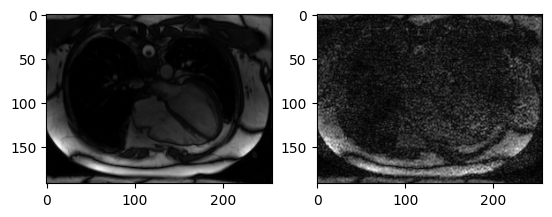

In [16]:
filepath = data_file_name

with h5py.File(filepath, 'r') as f:
    keys = list(f.keys())
    print(len(keys))
    for key in list(keys):
        print(key)
        clean_image = f[key]['clean'][()]
        noisy_image = f[key]['noisy'][()]
        noise_sigma = f[key]['noise_sigma'][()]

        print(clean_image.shape)
        print(noisy_image.shape)
        print(noise_sigma)

        fig, ax = plt.subplots(1,2)
        ax[0].imshow(clean_image, cmap='gray')
        ax[1].imshow(noisy_image, cmap='gray')
        plt.show()
        plt.close()

        break